In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [3]:
# !kaggle datasets download -d sbhatti/financial-sentiment-analysis
!kaggle datasets download -d abhi8923shriv/sentiment-analysis-dataset

 61% 33.0M/54.4M [00:00<00:00, 171MB/s]
100% 54.4M/54.4M [00:00<00:00, 190MB/s]


In [4]:
# !unzip financial-sentiment-analysis.zip
# !unzip twitter-entity-sentiment-analysis.zip
!unzip sentiment-analysis-dataset.zip


Archive:  sentiment-analysis-dataset.zip
  inflating: test.csv                
  inflating: testdata.manual.2009.06.14.csv  
  inflating: train.csv               
  inflating: training.1600000.processed.noemoticon.csv  


In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

In [6]:
# Download NLTK resources (you only need to do this once)
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
import pandas as pd

# Try different encodings to read the files
encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1', 'utf-16']
train_data = None
test_data = None
for encoding in encodings_to_try:
    try:
        train_data = pd.read_csv('/content/train.csv', encoding=encoding)
        # test_data = pd.read_csv('/content/test.csv', encoding=encoding)
        print("Files successfully read with encoding:", encoding)
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        print("Failed to read files with encoding:", encoding)

# Check if data has been loaded successfully
if train_data is not None and test_data is not None:
    # Now you can work with train_data and test_data DataFrames
    print("Train data shape:", train_data.shape)
    # print("Test data shape:", test_data.shape)
else:
    print("Failed to load data. Check file paths and try specifying different encodings.")


Failed to read files with encoding: utf-8
Files successfully read with encoding: latin-1
Failed to load data. Check file paths and try specifying different encodings.


In [8]:
train_data

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167


In [9]:
train_data.shape

(27481, 10)

In [10]:
train_data.describe()

,Population -2020,Land Area (Km²),Density (P/Km²)
count,2.748100e+04,2.748100e+04,27481.000000
mean,4.018497e+07,6.621730e+05,357.686583
std,1.504946e+08,1.807425e+06,2013.750702
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [11]:
train_data

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167


In [13]:
train_data.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [16]:
train_data.dropna(inplace= True)

In [17]:
train_data.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [ ]:
print(train_data.columns)

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')


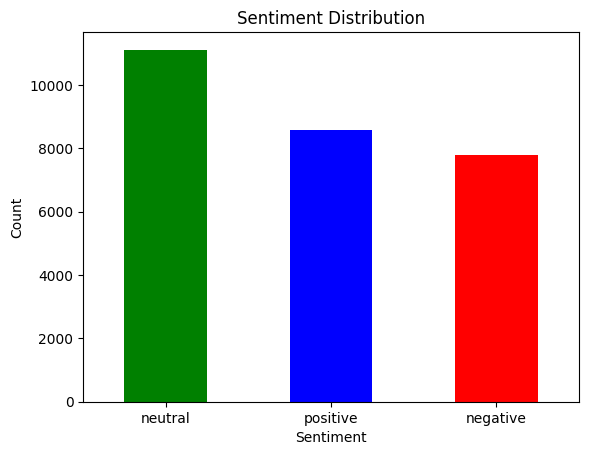

In [20]:
# Now, let's plot a bar graph for the count of positive and negative sentiments
import matplotlib.pyplot as plt

# Assuming 'sentiment' column contains 'positive' and 'negative' values
sentiment_counts = train_data['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['green','blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [22]:
import pandas as pd
from sklearn.utils import resample

# Assuming df is your DataFrame

# Step 1: Identify Class Imbalance
sentiment_counts = train_data['sentiment'].value_counts()

# Step 2: Determine the Target Number of Samples
target_num_samples = min(sentiment_counts)

# Step 3: Random Undersampling or Oversampling
balanced_data = pd.DataFrame(columns=train_data.columns)
for sentiment, count in sentiment_counts.items():
    # Undersample the majority class to match the target number of samples
    if count > target_num_samples:
        sampled_data = resample(train_data[train_data['sentiment'] == sentiment], n_samples=target_num_samples, random_state=42)
        balanced_data = pd.concat([balanced_data, sampled_data])
    else:
        balanced_data = pd.concat([balanced_data, train_data[train_data['sentiment'] == sentiment]])

# Now, balanced_data contains the balanced dataset where each sentiment category has an equal number of samples


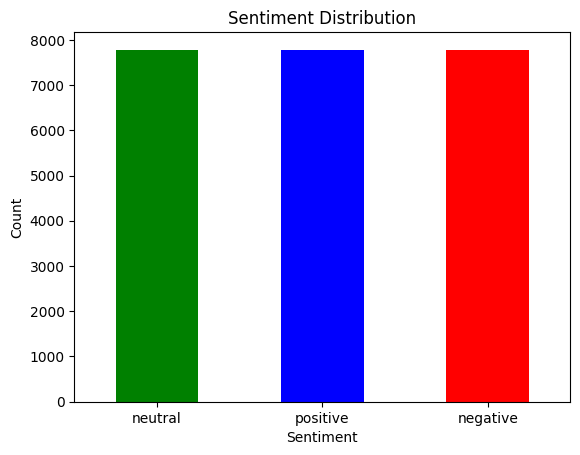

In [24]:
# Now, let's plot a bar graph for the count of positive and negative sentiments
import matplotlib.pyplot as plt

# Assuming 'sentiment' column contains 'positive' and 'negative' values
sentiment_counts = balanced_data['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['green','blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [26]:
train_data = balanced_data

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming df is your DataFrame containing the data
texts = balanced_data['text']

# Text preprocessing (e.g., lowercase, tokenization, etc.)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# Clustering using K-means
kmeans = KMeans(n_clusters=3)  # Choose the number of clusters
kmeans.fit(X)
cluster_labels = kmeans.labels_

# Evaluate clustering
silhouette_avg = silhouette_score(X, cluster_labels)
print("Silhouette Score:", silhouette_avg)

# Interpret clusters
balanced_data['cluster'] = cluster_labels
cluster_counts = balanced_data['cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.0027110171306893006
Cluster Counts:
cluster
0    16798
2     5902
1      643
Name: count, dtype: int64


In [27]:

# Define function for text preprocessing
def preprocess_text(text):

   # Check if text is a string
 if isinstance(text, str):
    # Tokenization
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text
 else:
        return ""  # Return empty string for non-string input

In [28]:
# Apply preprocessing to training and testing data
train_data['processed_message'] = train_data['text'].apply(preprocess_text)

In [29]:
train_data

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_message
17974,6d84858c19,Is anyone`s #visialvoicemail working. Have don...,Is anyone`s #visialvoicemail working. Have don...,neutral,noon,60-70,Saudi Arabia,34813871,2149690.0,16,anyone visialvoicemail working done sync Turne...
2200,cdc54f3006,Band work. I need my own laptop! buy me one I...,Band work. I need my own laptop! buy me one I...,neutral,noon,60-70,Nicaragua,6624554,120340.0,55,Band work need laptop buy one Ill drive shifts...
13355,59cf48529d,"working, my 4-day weekend is over, aah well a...","working, my 4-day weekend is over, aah well an...",neutral,night,70-100,Antigua and Barbuda,97929,440.0,223,working 4-day weekend aah well another one com...
12866,0bb896a8fe,Recording new songs,Recording new songs,neutral,night,31-45,Canada,37742154,9093510.0,4,Recording new songs
14205,8764d96d8f,living in ballarat again,living in ballarat again,neutral,morning,46-60,Hungary,9660351,90530.0,107,living ballarat
...,...,...,...,...,...,...,...,...,...,...,...
27464,e7eecffdc8,rec game....trying not to cry...the pain is to...,breakingg,negative,night,31-45,Equatorial Guinea,1402985,28050.0,50,rec game .... trying cry ... pain much .. need...
27470,778184dff1,lol i know and haha..did you fall asleep?? o...,t bored,negative,night,31-45,Finland,5540720,304000.0,18,lol know haha .. fall asleep get bored shaun p...
27472,8f5adc47ec,http://twitpic.com/663vr - Wanted to visit the...,were too late,negative,noon,60-70,Gabon,2225734,257670.0,9,http //twitpic.com/663vr Wanted visit animals ...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137,wish could come see u Denver husband lost job ...


In [30]:
train_data['sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [31]:
# Assuming train_data['Sentiment_Label'] contains the string labels

label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}

# Use the map function to replace labels with numerical values
train_data['Sentiment_Label_Encoded'] = train_data['sentiment'].map(label_mapping)

In [32]:
train_data['Sentiment_Label_Encoded'].unique()

array([2, 1, 0])

In [33]:
# Tokenize the preprocessed text data
tokenizer = Tokenizer(num_words=10000)  # Limit the vocabulary size to 10,000 words
tokenizer.fit_on_texts(train_data['processed_message'])


In [36]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Later, to load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)


In [37]:
X_train = tokenizer.texts_to_sequences(train_data['processed_message'])

In [38]:
# Pad sequences to ensure uniform length
max_sequence_length = max(len(sequence) for sequence in X_train)
print(max_sequence_length)
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post')

27


In [39]:
# Define the CNN model architecture
embedding_dim = 100  # Dimensionality of the word embeddings
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (+1 for padding token)
num_filters = 128  # Number of filters in the convolutional layer
kernel_size = 5  # Size of the convolutional kernel
hidden_dim = 64  # Dimensionality of the hidden layer

# Code for plotting confusion matrix

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Normal Cnn Model

In [41]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Define the CNN model architecture
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    Conv1D(num_filters, kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(hidden_dim, activation='relu'),
    Dense(3, activation='softmax')  # Output layer for multi-class classification (4 classes) //positive.negative,neuttal,irrelevant
])




In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 100)           2047500   
                                                                 
 conv1d (Conv1D)             (None, 23, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2120079 (8.09 MB)
Trainable params: 2120079 (8.09 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [43]:

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [44]:
# Train the model
history = model.fit(X_train, train_data['Sentiment_Label_Encoded'], epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
292/292 [==============================] - 22s 60ms/step - loss: 0.7645 - accuracy: 0.6682 - val_loss: 1.2540 - val_accuracy: 0.4378
Epoch 2/10
292/292 [==============================] - 3s 11ms/step - loss: 0.3885 - accuracy: 0.8567 - val_loss: 1.0333 - val_accuracy: 0.5663
Epoch 3/10
292/292 [==============================] - 4s 15ms/step - loss: 0.1676 - accuracy: 0.9449 - val_loss: 1.1406 - val_accuracy: 0.6106
Epoch 4/10
292/292 [==============================] - 2s 7ms/step - loss: 0.0777 - accuracy: 0.9757 - val_loss: 1.4998 - val_accuracy: 0.5856
Epoch 5/10
292/292 [==============================] - 2s 6ms/step - loss: 0.0433 - accuracy: 0.9876 - val_loss: 1.5809 - val_accuracy: 0.6252
Epoch 6/10
292/292 [==============================] - 2s 7ms/step - loss: 0.0302 - accuracy: 0.9910 - val_loss: 2.0618 - val_accuracy: 0.5652
Epoch 7/10
292/292 [==============================] - 2s 5ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 1.8608 - val_accuracy: 0.6162
Ep

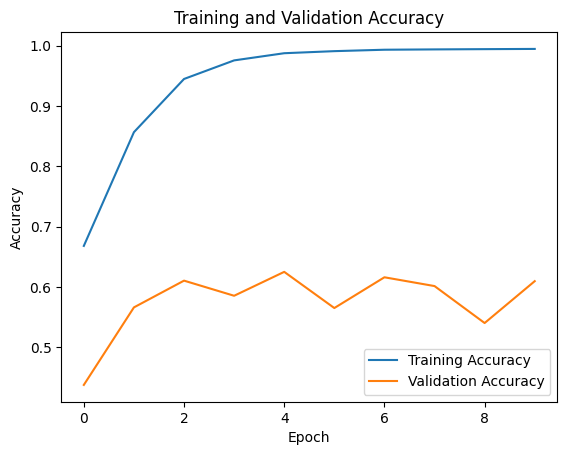

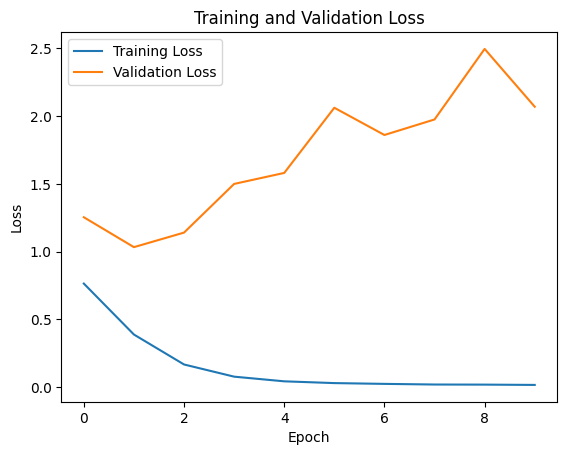

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [46]:
# Evaluate the model
_, accuracy = model.evaluate(X_train, train_data['Sentiment_Label_Encoded'])
print("Accuracy:", accuracy)

730/730 [==============================] - 2s 2ms/step - loss: 0.4233 - accuracy: 0.9187
Accuracy: 0.9186908006668091


In [47]:
model.save('M1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 0s 2ms/step


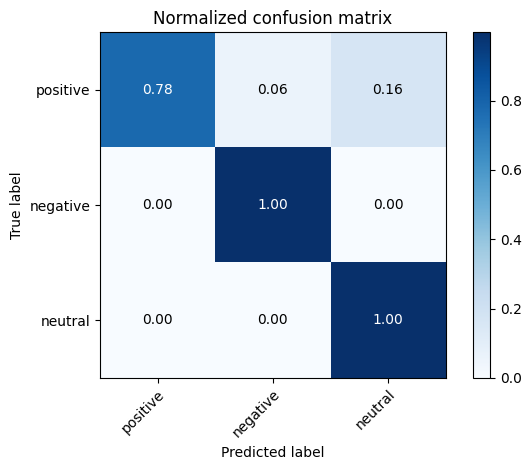

584/584 [==============================] - 2s 3ms/step - loss: 0.4277 - accuracy: 0.9177
Training Accuracy: 0.9176930785179138


In [50]:
from sklearn.model_selection import train_test_split

# Define the class labels
class_names = ['positive', 'negative', 'neutral']

# Split the training data into training and validation sets
X_train1, X_val, y_train, y_val = train_test_split(X_train, train_data['Sentiment_Label_Encoded'], test_size=0.2, random_state=42)

# Train the model on the training set
# history = model.fit(X_train1, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Get predicted probabilities for each class on the validation set
y_pred_probs = model.predict(X_val)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Evaluate the model on the training set
_, accuracy = model.evaluate(X_train1, y_train)
print("Training Accuracy:", accuracy)


# LSTM Model

In [51]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


In [52]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 27, 100)           2047500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2173199 (8.29 MB)
Trainable params: 2173199 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:

# Compile the model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [54]:
# Train the model
history_lstm = model_lstm.fit(X_train, train_data['Sentiment_Label_Encoded'], epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
292/292 [==============================] - 45s 140ms/step - loss: 0.8817 - accuracy: 0.5678 - val_loss: 1.2431 - val_accuracy: 0.3635
Epoch 2/10
292/292 [==============================] - 42s 144ms/step - loss: 0.5672 - accuracy: 0.7867 - val_loss: 1.3858 - val_accuracy: 0.4191
Epoch 3/10
292/292 [==============================] - 36s 124ms/step - loss: 0.4244 - accuracy: 0.8506 - val_loss: 1.0975 - val_accuracy: 0.5419
Epoch 4/10
292/292 [==============================] - 38s 129ms/step - loss: 0.3467 - accuracy: 0.8827 - val_loss: 1.4349 - val_accuracy: 0.5046
Epoch 5/10
292/292 [==============================] - 31s 107ms/step - loss: 0.2901 - accuracy: 0.9061 - val_loss: 1.1485 - val_accuracy: 0.5913
Epoch 6/10
292/292 [==============================] - 46s 157ms/step - loss: 0.2498 - accuracy: 0.9181 - val_loss: 1.2768 - val_accuracy: 0.5828
Epoch 7/10
292/292 [==============================] - 27s 94ms/step - loss: 0.2294 - accuracy: 0.9240 - val_loss: 1.7737 - val_acc

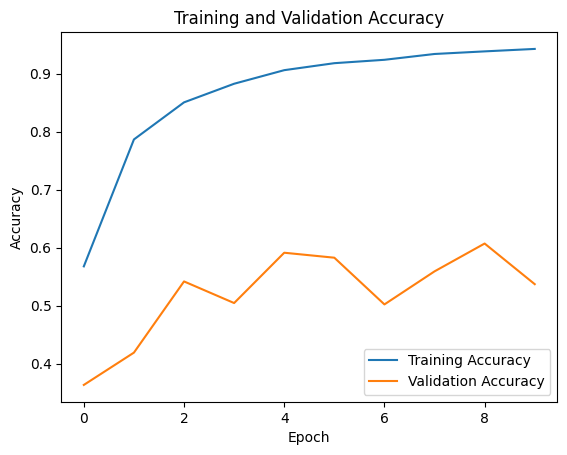

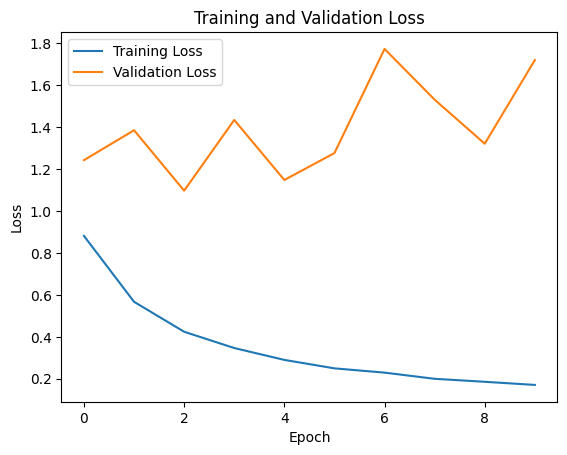

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot training and validation accuracy over epochs
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss over epochs
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [56]:
# Evaluate the model
_, accuracy = model_lstm.evaluate(X_train, train_data['Sentiment_Label_Encoded'])
print("Accuracy:", accuracy)

730/730 [==============================] - 7s 9ms/step - loss: 0.4401 - accuracy: 0.8741
Accuracy: 0.8740521669387817


In [57]:
model_lstm.save('M_lstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 2s 8ms/step


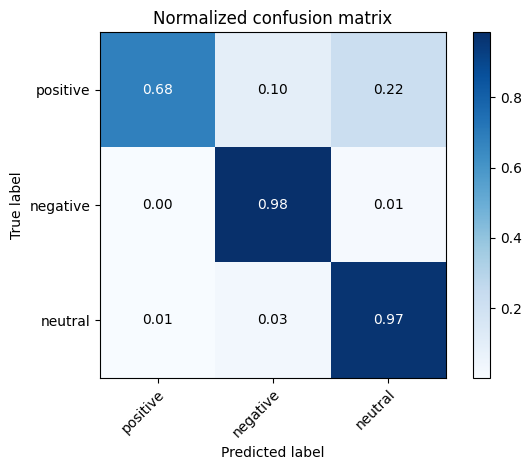

584/584 [==============================] - 5s 9ms/step - loss: 0.4424 - accuracy: 0.8735
Training Accuracy: 0.8735139966011047


In [58]:
from sklearn.model_selection import train_test_split

# Define the class labels
class_names = ['positive', 'negative', 'neutral']

# Split the training data into training and validation sets
X_train1, X_val, y_train, y_val = train_test_split(X_train, train_data['Sentiment_Label_Encoded'], test_size=0.2, random_state=42)

# Train the model on the training set
# history = model.fit(X_train1, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Get predicted probabilities for each class on the validation set
y_pred_probs = model_lstm.predict(X_val)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Evaluate the model on the training set
_, accuracy = model_lstm.evaluate(X_train1, y_train)
print("Training Accuracy:", accuracy)


# LSTM With Attention Mechanism

In [59]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Multiply, concatenate, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Assuming vocab_size, embedding_dim, max_sequence_length are defined
inputs = Input(shape=(max_sequence_length,))
embedding = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(inputs)
lstm_output = LSTM(64, return_sequences=True)(embedding)

# Attention mechanism
attention = Dense(1, activation='tanh')(lstm_output)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(64)(attention)
attention = Permute([2, 1])(attention)

# Apply the attention weights
weighted_output = Multiply()([lstm_output, attention])
weighted_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_output)

# Fully connected layers
dense1 = Dense(64, activation='relu')(weighted_sum)
output = Dense(3, activation='softmax')(dense1)

model_lstm_attention = Model(inputs=inputs, outputs=output)


In [60]:
model_lstm_attention.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 27)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 27, 100)              2047500   ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 27, 64)               42240     ['embedding_2[0][0]']         
                                                                                                  
 dense_4 (Dense)             (None, 27, 1)                65        ['lstm_1[0][0]']              
                                                                                              

In [61]:
model_lstm_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [62]:
history_lstm_attention = model_lstm_attention.fit(X_train, train_data['Sentiment_Label_Encoded'], epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
292/292 [==============================] - 17s 47ms/step - loss: 0.7889 - accuracy: 0.6434 - val_loss: 1.2365 - val_accuracy: 0.4341
Epoch 2/10
292/292 [==============================] - 4s 14ms/step - loss: 0.4818 - accuracy: 0.8216 - val_loss: 1.0662 - val_accuracy: 0.5843
Epoch 3/10
292/292 [==============================] - 3s 10ms/step - loss: 0.3588 - accuracy: 0.8735 - val_loss: 1.0038 - val_accuracy: 0.6303
Epoch 4/10
292/292 [==============================] - 3s 10ms/step - loss: 0.2905 - accuracy: 0.9002 - val_loss: 1.4191 - val_accuracy: 0.5185
Epoch 5/10
292/292 [==============================] - 3s 10ms/step - loss: 0.2461 - accuracy: 0.9126 - val_loss: 1.6034 - val_accuracy: 0.5549
Epoch 6/10
292/292 [==============================] - 3s 11ms/step - loss: 0.2103 - accuracy: 0.9240 - val_loss: 1.7160 - val_accuracy: 0.5629
Epoch 7/10
292/292 [==============================] - 3s 9ms/step - loss: 0.1824 - accuracy: 0.9332 - val_loss: 1.6794 - val_accuracy: 0.5873

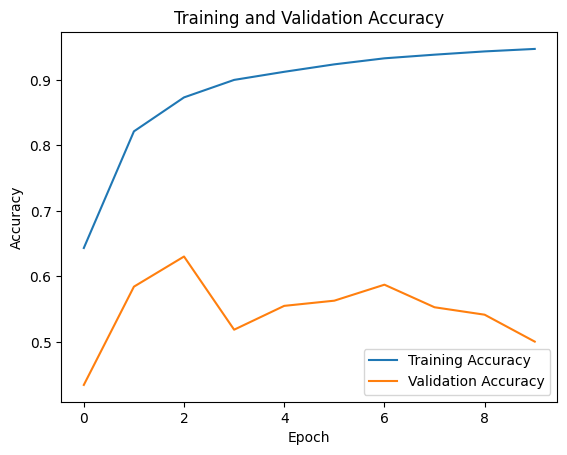

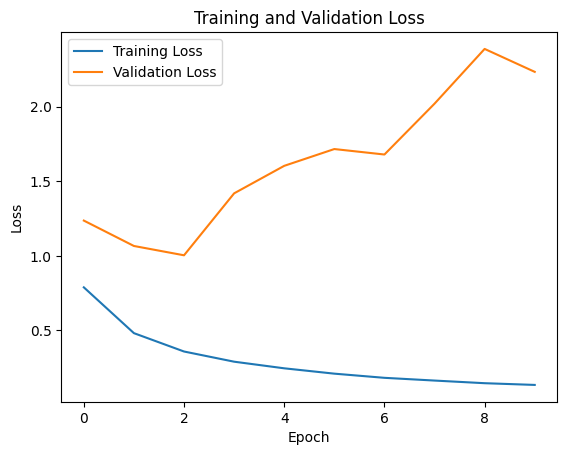

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot training and validation accuracy over epochs
plt.plot(history_lstm_attention.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm_attention.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss over epochs
plt.plot(history_lstm_attention.history['loss'], label='Training Loss')
plt.plot(history_lstm_attention.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [64]:
# Evaluate the model
_, accuracy = model_lstm_attention.evaluate(X_train, train_data['Sentiment_Label_Encoded'])
print("Accuracy:", accuracy)

730/730 [==============================] - 3s 4ms/step - loss: 0.5337 - accuracy: 0.8643
Accuracy: 0.8642848134040833


In [65]:
model_lstm_attention.save('Model_lstm_attention.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 1s 3ms/step


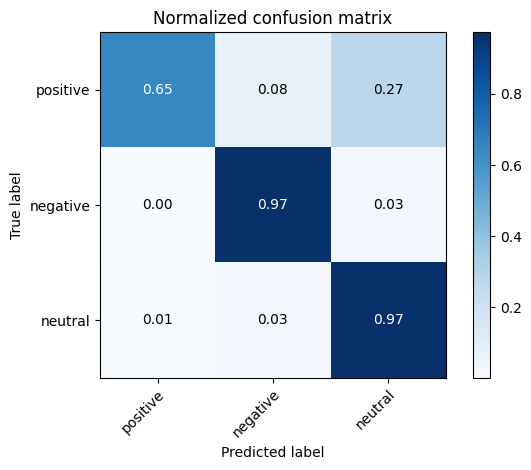

584/584 [==============================] - 2s 4ms/step - loss: 0.5382 - accuracy: 0.8646
Training Accuracy: 0.8646246194839478


In [66]:
from sklearn.model_selection import train_test_split

# Define the class labels
class_names = ['positive', 'negative', 'neutral']

# Split the training data into training and validation sets
X_train1, X_val, y_train, y_val = train_test_split(X_train, train_data['Sentiment_Label_Encoded'], test_size=0.2, random_state=42)

# Train the model on the training set
# history = model.fit(X_train1, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Get predicted probabilities for each class on the validation set
y_pred_probs = model_lstm_attention.predict(X_val)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Evaluate the model on the training set
_, accuracy = model_lstm_attention.evaluate(X_train1, y_train)
print("Training Accuracy:", accuracy)


# Bidirectional LSTM

In [67]:
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


In [68]:
model_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 27, 100)           2047500   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2140431 (8.17 MB)
Trainable params: 2140431 (8.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model_bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [70]:
history_bilstm = model_bilstm.fit(X_train, train_data['Sentiment_Label_Encoded'], epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
292/292 [==============================] - 18s 45ms/step - loss: 0.7746 - accuracy: 0.6516 - val_loss: 1.2313 - val_accuracy: 0.4556
Epoch 2/10
292/292 [==============================] - 4s 14ms/step - loss: 0.4677 - accuracy: 0.8255 - val_loss: 1.3076 - val_accuracy: 0.5145
Epoch 3/10
292/292 [==============================] - 3s 10ms/step - loss: 0.3254 - accuracy: 0.8842 - val_loss: 1.1740 - val_accuracy: 0.6061
Epoch 4/10
292/292 [==============================] - 3s 11ms/step - loss: 0.2465 - accuracy: 0.9160 - val_loss: 1.4391 - val_accuracy: 0.5779
Epoch 5/10
292/292 [==============================] - 4s 14ms/step - loss: 0.1918 - accuracy: 0.9354 - val_loss: 1.8618 - val_accuracy: 0.5352
Epoch 6/10
292/292 [==============================] - 2s 8ms/step - loss: 0.1516 - accuracy: 0.9494 - val_loss: 1.7512 - val_accuracy: 0.6070
Epoch 7/10
292/292 [==============================] - 2s 8ms/step - loss: 0.1269 - accuracy: 0.9572 - val_loss: 2.0702 - val_accuracy: 0.5560


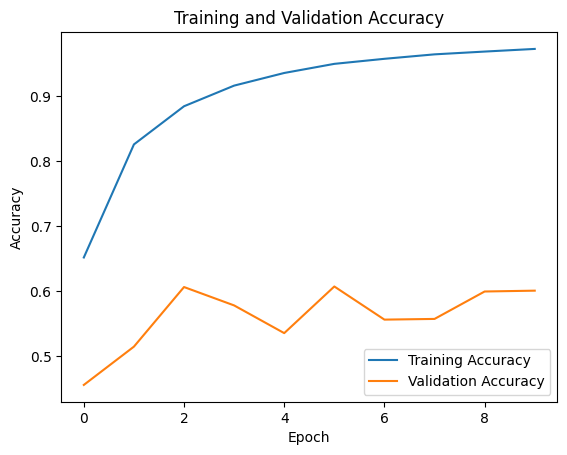

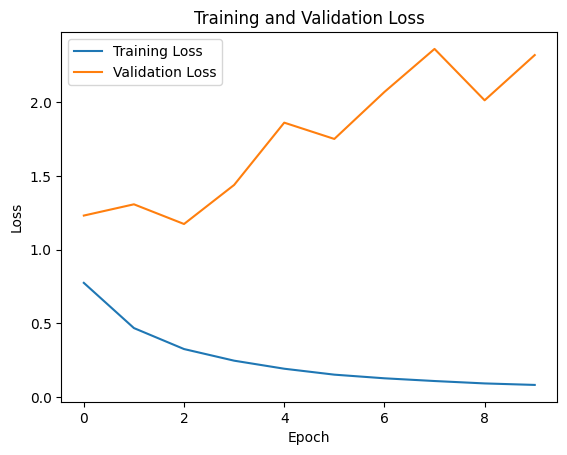

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot training and validation accuracy over epochs
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss over epochs
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [72]:
# Evaluate the model
_, accuracy = model_bilstm.evaluate(X_train, train_data['Sentiment_Label_Encoded'])
print("Accuracy:", accuracy)

730/730 [==============================] - 3s 4ms/step - loss: 0.5126 - accuracy: 0.9043
Accuracy: 0.9042968153953552


In [73]:
model_bilstm.save('Model_bilstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 1s 3ms/step


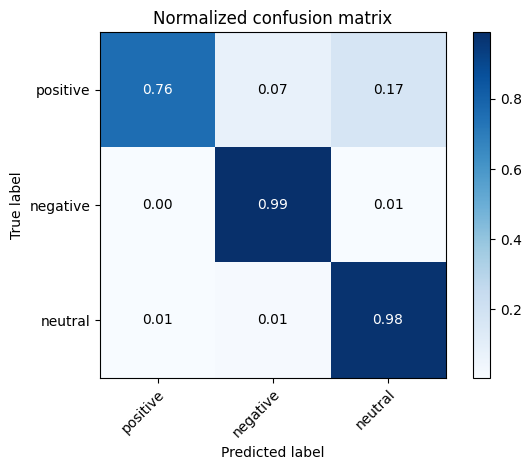

584/584 [==============================] - 3s 4ms/step - loss: 0.5218 - accuracy: 0.9033
Training Accuracy: 0.90334153175354


In [74]:
from sklearn.model_selection import train_test_split

# Define the class labels
class_names = ['positive', 'negative', 'neutral']

# Split the training data into training and validation sets
X_train1, X_val, y_train, y_val = train_test_split(X_train, train_data['Sentiment_Label_Encoded'], test_size=0.2, random_state=42)

# Train the model on the training set
# history = model.fit(X_train1, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Get predicted probabilities for each class on the validation set
y_pred_probs = model_bilstm.predict(X_val)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Evaluate the model on the training set
_, accuracy = model_bilstm.evaluate(X_train1, y_train)
print("Training Accuracy:", accuracy)


# GRU Model

In [75]:
from tensorflow.keras.layers import GRU

# Define the model architecture
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

Epoch 1/10
292/292 [==============================] - 37s 113ms/step - loss: 1.0326 - accuracy: 0.4177 - val_loss: 1.9595 - val_accuracy: 0.0000e+00
Epoch 2/10
292/292 [==============================] - 26s 91ms/step - loss: 1.0295 - accuracy: 0.4146 - val_loss: 1.7329 - val_accuracy: 0.0000e+00
Epoch 3/10
292/292 [==============================] - 26s 90ms/step - loss: 0.9744 - accuracy: 0.4763 - val_loss: 1.2602 - val_accuracy: 0.3354
Epoch 4/10
292/292 [==============================] - 25s 86ms/step - loss: 0.6147 - accuracy: 0.7614 - val_loss: 1.0362 - val_accuracy: 0.5132
Epoch 5/10
292/292 [==============================] - 27s 91ms/step - loss: 0.4342 - accuracy: 0.8495 - val_loss: 1.0423 - val_accuracy: 0.5804
Epoch 6/10
292/292 [==============================] - 27s 93ms/step - loss: 0.3372 - accuracy: 0.8912 - val_loss: 1.1791 - val_accuracy: 0.5639
Epoch 7/10
292/292 [==============================] - 27s 92ms/step - loss: 0.2807 - accuracy: 0.9112 - val_loss: 1.3695 - val_

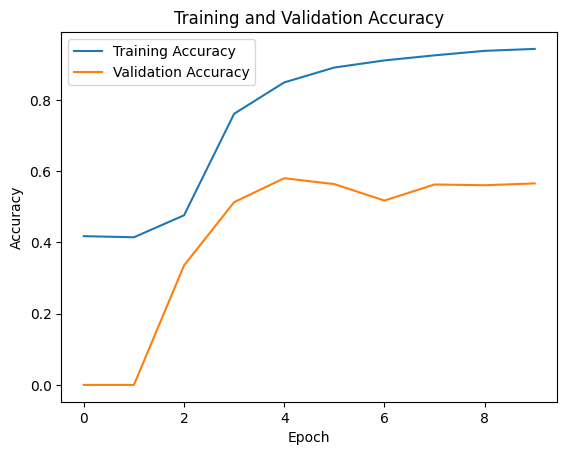

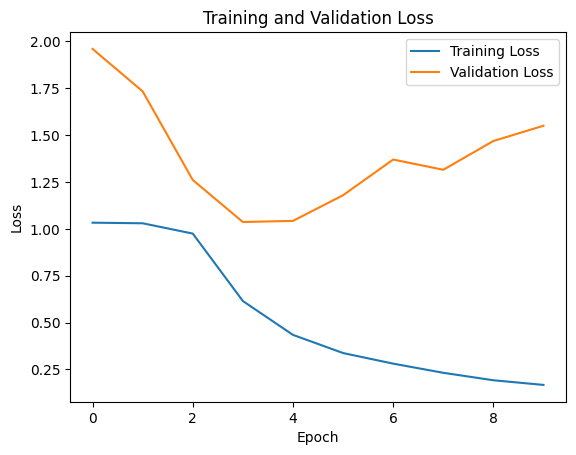

In [76]:
model_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_gru = model_gru.fit(X_train, train_data['Sentiment_Label_Encoded'], epochs=10, batch_size=64, validation_split=0.2)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot training and validation accuracy over epochs
plt.plot(history_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss over epochs
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [77]:
# Evaluate the model
_, accuracy = model_gru.evaluate(X_train, train_data['Sentiment_Label_Encoded'])
print("Accuracy:", accuracy)

730/730 [==============================] - 7s 9ms/step - loss: 0.4078 - accuracy: 0.8806
Accuracy: 0.8806065917015076


In [78]:
model_gru.save('Model_Gru.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 1s 8ms/step


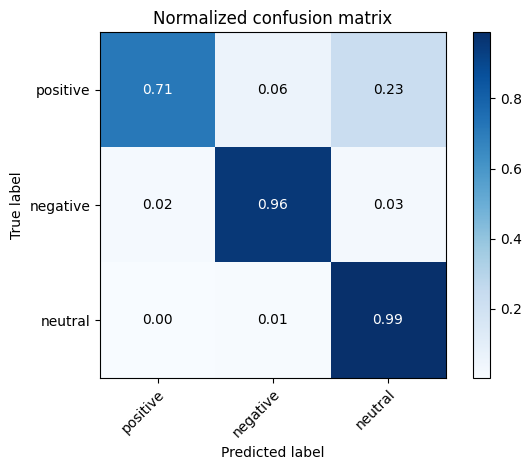

584/584 [==============================] - 6s 11ms/step - loss: 0.4113 - accuracy: 0.8796
Training Accuracy: 0.8795651793479919


In [79]:
from sklearn.model_selection import train_test_split

# Define the class labels
class_names = ['positive', 'negative', 'neutral']

# Split the training data into training and validation sets
X_train1, X_val, y_train, y_val = train_test_split(X_train, train_data['Sentiment_Label_Encoded'], test_size=0.2, random_state=42)

# Train the model on the training set
# history = model.fit(X_train1, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Get predicted probabilities for each class on the validation set
y_pred_probs = model_gru.predict(X_val)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Evaluate the model on the training set
_, accuracy = model_gru.evaluate(X_train1, y_train)
print("Training Accuracy:", accuracy)


# Testing All model to show results

In [83]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import numpy as np



# Load the trained model
loaded_model = load_model('/content/M1.h5')
# loaded_model = load_model('/content/Model_lstm_attention.h5')
# loaded_model = load_model('/content/Model_lstm_attention.h5')
# import pickle






In [86]:
# Define function for text preprocessing
def preprocess_text(text):
    # Check if text is a string
    if isinstance(text, str):
        # Tokenization
        tokens = word_tokenize(text)

        # Remove punctuation
        tokens = [word for word in tokens if word not in string.punctuation]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

        # Join tokens back into a string
        preprocessed_text = ' '.join(tokens)

        return preprocessed_text
    else:
        return ""  # Return empty string for non-string input


# Define the function for testing
def test_model(input_text):
    # Preprocess the input text
    preprocessed_text = preprocess_text(input_text)

    # Tokenize the preprocessed text
    input_sequence = tokenizer.texts_to_sequences([preprocessed_text])

    # Pad the sequence
    padded_input_sequence = pad_sequences(input_sequence, maxlen=27, padding='post')

    # Make predictions
    prediction = loaded_model.predict(np.array(padded_input_sequence))

        # Assuming your model prediction is stored in the variable 'prediction'
    predicted_numerical_label = np.argmax(prediction)

    label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}

    # Reverse mapping from numerical label to original label
    predicted_sentiment_label = [key for key, value in label_mapping.items() if value == predicted_numerical_label][0]


    return predicted_sentiment_label



In [87]:
# Example usage
input_string = "i like your product it is very good"
result = test_model(input_string)
print("Predicted Sentiment:", result)

1/1 [==============================] - 0s 194ms/step
Predicted Sentiment: positive


In [88]:
# Example usage
input_string = "Waste of money i dont like it is bad one"
result = test_model(input_string)
print("Predicted Sentiment:", result)

1/1 [==============================] - 0s 18ms/step
Predicted Sentiment: negative


In [89]:
# Example usage
input_string = " i will kill you i dont like you!"
result = test_model(input_string)
print("Predicted Sentiment:", result)

1/1 [==============================] - 0s 17ms/step
Predicted Sentiment: negative


In [90]:
# Example usage
input_string = 'what interview! leave me alone'
result = test_model(input_string)
print("Predicted Sentiment:", result)

1/1 [==============================] - 0s 17ms/step
Predicted Sentiment: negative


In [92]:
# Example usage for sentence 1
input_string = "I love sunny days at the beach!"
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 2
input_string = "The movie was fantastic, I enjoyed every minute of it."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 3
input_string = "My dog makes me smile every day."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 4
input_string = "Traffic jams are so frustrating, they ruin my mood."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 5
input_string = "The food at that restaurant was terrible, I won't go back."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 6
input_string = "Winning the lottery would be a dream come true."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 7
input_string = "I feel so lonely when I'm far away from my family."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 8
input_string = "My best friend always knows how to cheer me up."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 9
input_string = "Getting a promotion at work was the highlight of my year."
result = test_model(input_string)
print("Predicted Sentiment:", result)

# Example usage for sentence 10
input_string = "I'm so grateful for all the support I've received from my friends."
result = test_model(input_string)
print("Predicted Sentiment:", result)

1/1 [==============================] - 0s 68ms/step
Predicted Sentiment: positive
1/1 [==============================] - 0s 52ms/step
Predicted Sentiment: positive
1/1 [==============================] - 0s 51ms/step
Predicted Sentiment: positive
1/1 [==============================] - 0s 53ms/step
Predicted Sentiment: negative
1/1 [==============================] - 0s 73ms/step
Predicted Sentiment: negative
1/1 [==============================] - 0s 39ms/step
Predicted Sentiment: neutral
1/1 [==============================] - 0s 59ms/step
Predicted Sentiment: negative
1/1 [==============================] - 0s 59ms/step
Predicted Sentiment: positive
1/1 [==============================] - 0s 65ms/step
Predicted Sentiment: positive
1/1 [==============================] - 0s 38ms/step
Predicted Sentiment: positive
